In [1]:
import torch
import numpy as np
from dist_ae import SetAutoencoderGNN, SetAutoencoderTx, train_w_stop
from distns import distns
from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distn_name = 'poisson'
pois_generate_params = distns[distn_name]['generate_params']
pois_sample_distn = distns[distn_name]['sample']

distn_name = 'normal'
normal_generate_params = distns[distn_name]['generate_params']
normal_sample_distn = distns[distn_name]['sample']

In [18]:
def mix_distributions(dist_fns, set_number, set_size, n_features):
    """generate mixed dataset from given distributions and proportions!"""
    sets = []
    for generate_params, sample_distn, prop in dist_fns:
        num_samples = int(set_number * prop)
        params = generate_params(num_samples, n_features)
        sets.append(sample_distn(*params, num_samples, set_size, n_features))
    return np.concatenate(sets, axis=0)

n_features = 2
set_number = 5000 
set_size = 10**3
proportions = [0.5, 0.5]

# prepare functions
pois_fns = (pois_generate_params, pois_sample_distn, proportions[0])
normal_fns = (normal_generate_params, normal_sample_distn, proportions[1])

dist_fns = [pois_fns, normal_fns]

# generate datasets
x_train = mix_distributions(dist_fns, set_number, set_size, n_features)
x_val = mix_distributions(dist_fns, set_number // 2, set_size, n_features)
x_test = mix_distributions(dist_fns, set_number // 2, set_size, n_features)
test_labels = ['Poisson']*int(proportions[0]*set_number//2) + ['Normal']*int(proportions[1]*set_number//2)

# create dataloaders
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.from_numpy(x_val).float(), batch_size=32, shuffle=False)

In [10]:
dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

dist_ae = train_w_stop(dist_ae, optimizer, 
                    train_loader, val_loader,
                    max_epochs = 300, device='cuda',
                    verbose=True)

with torch.no_grad():
    z, rec = dist_ae(torch.from_numpy(x_test).float().cuda())

Epoch 1 | Train Loss: 1875.3926 | Val Loss: 806.1495
Epoch 2 | Train Loss: 585.0264 | Val Loss: 274.2207
Epoch 3 | Train Loss: 155.2966 | Val Loss: 113.5219
Epoch 4 | Train Loss: 114.1629 | Val Loss: 142.8387
Epoch 5 | Train Loss: 103.1652 | Val Loss: 87.6402
Epoch 6 | Train Loss: 92.6971 | Val Loss: 84.2486
Epoch 7 | Train Loss: 100.8957 | Val Loss: 100.3175
Epoch 8 | Train Loss: 101.1043 | Val Loss: 78.1382
Epoch 9 | Train Loss: 80.6638 | Val Loss: 77.4573
Epoch 10 | Train Loss: 79.4715 | Val Loss: 73.7475
Epoch 11 | Train Loss: 76.7251 | Val Loss: 81.4170
Epoch 12 | Train Loss: 75.8674 | Val Loss: 73.4399
Epoch 13 | Train Loss: 75.5531 | Val Loss: 71.0313
Epoch 14 | Train Loss: 75.9387 | Val Loss: 66.9761
Epoch 15 | Train Loss: 73.0890 | Val Loss: 93.5865
Epoch 16 | Train Loss: 70.8464 | Val Loss: 61.1037
Epoch 17 | Train Loss: 68.9551 | Val Loss: 62.1817
Epoch 18 | Train Loss: 66.7837 | Val Loss: 60.1340
Epoch 19 | Train Loss: 60.3481 | Val Loss: 61.7161
Epoch 20 | Train Loss: 58.6

In [11]:
from umap import UMAP

In [14]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(z.cpu().numpy())

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

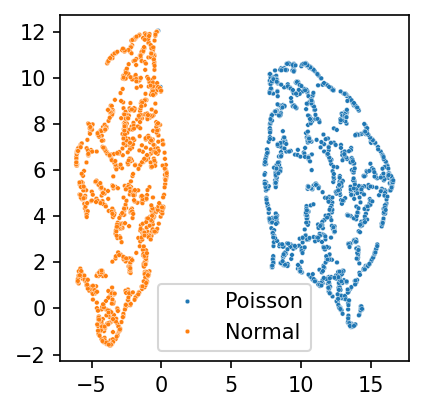

In [22]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=test_labels, s=5)